# Linear regression by gradient descent 
Math 395 Learning from Large Data Sets 

Fall 2024, Hope College

## import libraries

In [20]:
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib import cm

## simulate a data set (single feature)

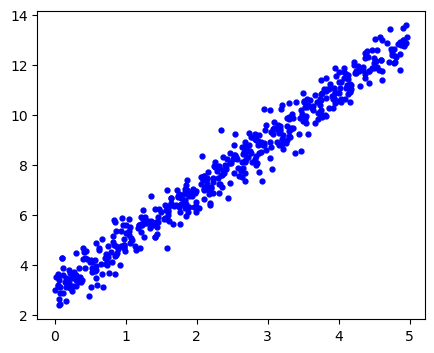

In [21]:
n_1 = 500 # number of examples

x = np.random.uniform(0,5,n_1); # feature
x = np.sort(x); 

y = 3 + 2 * x  # true beta0 = 3, true beta1 = 2
y = y + 0.5 * np.random.randn(n_1)  # add Gaussian noise

x = np.reshape(x,[-1,1]) # change to column form
y = np.reshape(y,[-1,1])

plt.figure(figsize=(5,4))
plt.plot(x,y,'b.', markersize=7)

## linear regression by the exact method

[2.97872446] [[2.01350338]]


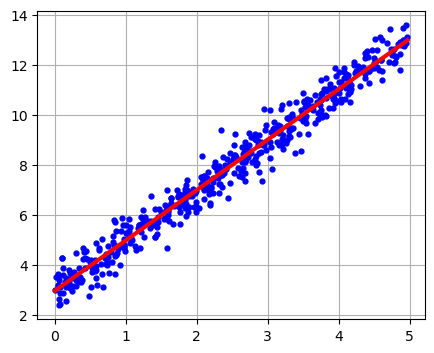

In [22]:
LRmodel = LinearRegression().fit(x, y)  # fit a linear reg model with intercept

beta0 = LRmodel.intercept_    # beta_0
beta1 = LRmodel.coef_         # beta_1

print(beta0,beta1)

yhat = LRmodel.predict(x)     # fitted values

plt.figure(figsize=(5,4))
plt.plot(x,y,'b.', markersize=7)
plt.plot(x,yhat,'r-', linewidth=3)
plt.grid('on')

## (1) Display level sets of the objective function (training MSE). Remember to set the limits of the variables by centering around their true values

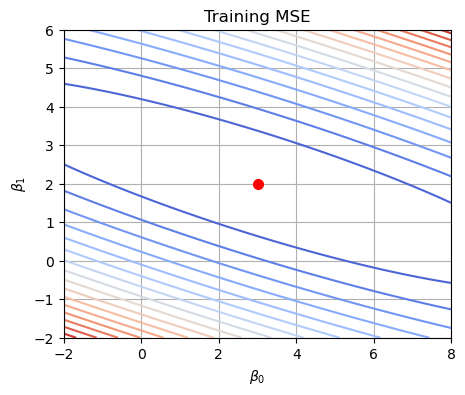

In [23]:
n = 300

beta0 = np.linspace(-2,8,n)
beta1 = np.linspace(-2,6,n)
B0, B1 = np.meshgrid(beta0, beta1)

MSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        yhat = B0[i,j] + B1[i,j] * x
        MSE[i,j] = np.mean((y - yhat)**2)

plt.figure(figsize=(5,4))
plt.contour(B0, B1, MSE, 20, cmap=cm.coolwarm)
plt.plot(3,2,'ro', markersize=7)
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.title('Training MSE')
plt.grid('on')

## (2) Implement linear regression by gradient descent, try different values for the learning rate parameter $\eta$ (such as 0.05, 0.1, 0.2) and display the f-convergence curves. When the curve converges, what should the limit of the curve be?

In [24]:
def gradient_descent(x, y, eta, n_iter, beta0=0, beta1=0):
    mse = np.zeros(n_iter)
    beta0s = np.zeros(n_iter)
    beta1s = np.zeros(n_iter)

    beta0s[0] = beta0
    beta1s[0] = beta1
    mse[0] = np.mean((y - (beta0 + beta1 * x))**2)
    for i in range(n_iter):
        yhat = beta0 + beta1 * x
        
        grad_beta0 = -2 * np.mean(y - yhat)
        grad_beta1 = -2 * np.mean((y - yhat) * x)

        beta0 = beta0 - eta * grad_beta0
        beta1 = beta1 - eta * grad_beta1

        mse[i] = np.mean((y - yhat)**2)
        beta0s[i] = beta0
        beta1s[i] = beta1
    return beta0s, beta1s, mse

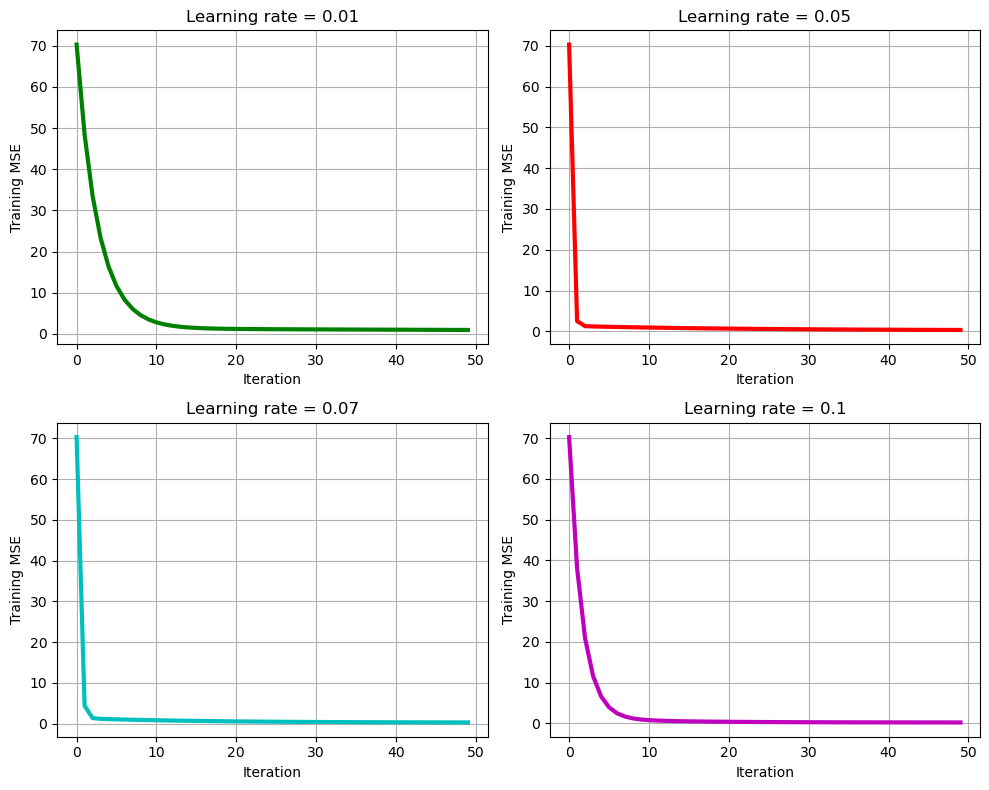

In [25]:
eta_values = [0.01, 0.05, 0.07, 0.1]
n_iter = 50

colors = ['g', 'r', 'c', 'm']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0, beta1, mse = gradient_descent(x=x, y=y, eta=eta, n_iter=n_iter, beta0=beta0, beta1=beta1)
    axs[idx].plot(mse, f'{color}-', linewidth=3)
    axs[idx].set_xlabel('Iteration')
    axs[idx].set_ylabel('Training MSE')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].grid('on')

plt.tight_layout()
plt.show()

## (3) Display the trajectory of gradient descent on top of level sets, for the different values of $\eta$

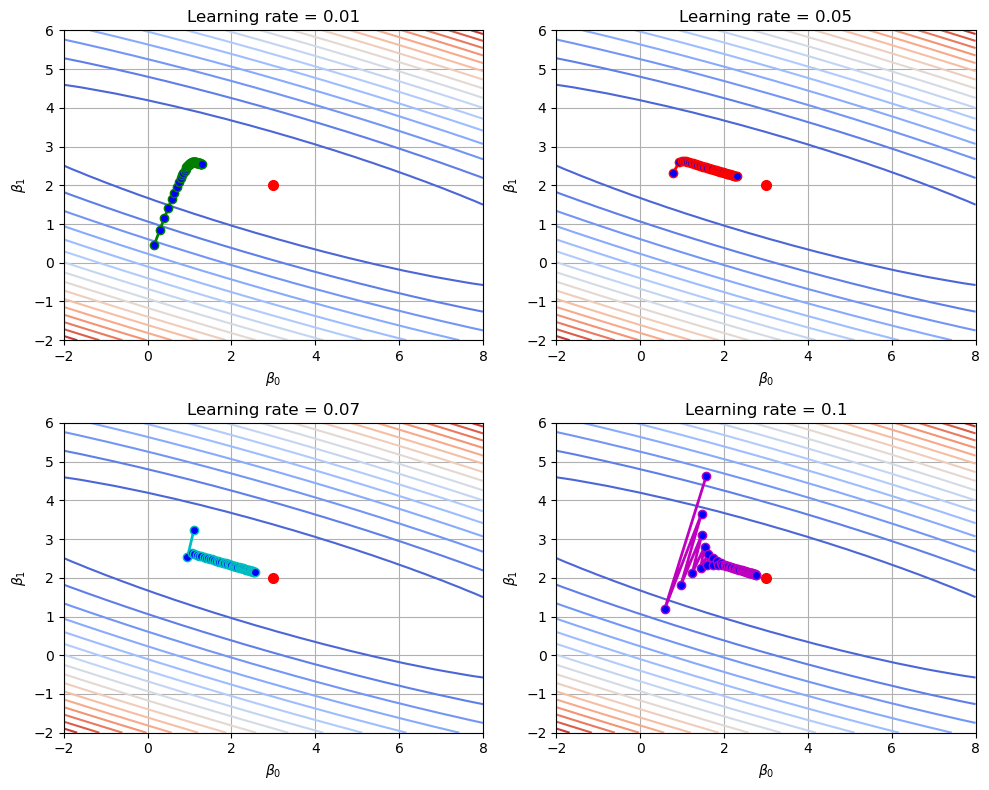

In [26]:
n = 50

beta0 = np.linspace(-2,8,n)
beta1 = np.linspace(-2,6,n)
B0, B1 = np.meshgrid(beta0, beta1)

MSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        yhat = B0[i,j] + B1[i,j] * x
        MSE[i,j] = np.mean((y - yhat)**2)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

eta_values = [0.01, 0.05, 0.07, 0.1]
colors = ['g', 'r', 'c', 'm']

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0s, beta1s, mse = gradient_descent(x=x, y=y, eta=eta, n_iter=n_iter, beta0=beta0, beta1=beta1)
    axs[idx].contour(B0, B1, MSE, 20, cmap=cm.coolwarm)
    axs[idx].plot(beta0s, beta1s, f'{color}-', linewidth=2, marker='o', markerfacecolor='b', markersize=6)
    axs[idx].set_xlabel(r'$\beta_0$')
    axs[idx].set_ylabel(r'$\beta_1$')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].plot(3,2,'ro', markersize=7)
    axs[idx].grid('on')

plt.tight_layout()
plt.show()

## (4) Display the fitted lines (on top of data) at every step of gradient descent, with the best learning rate found above

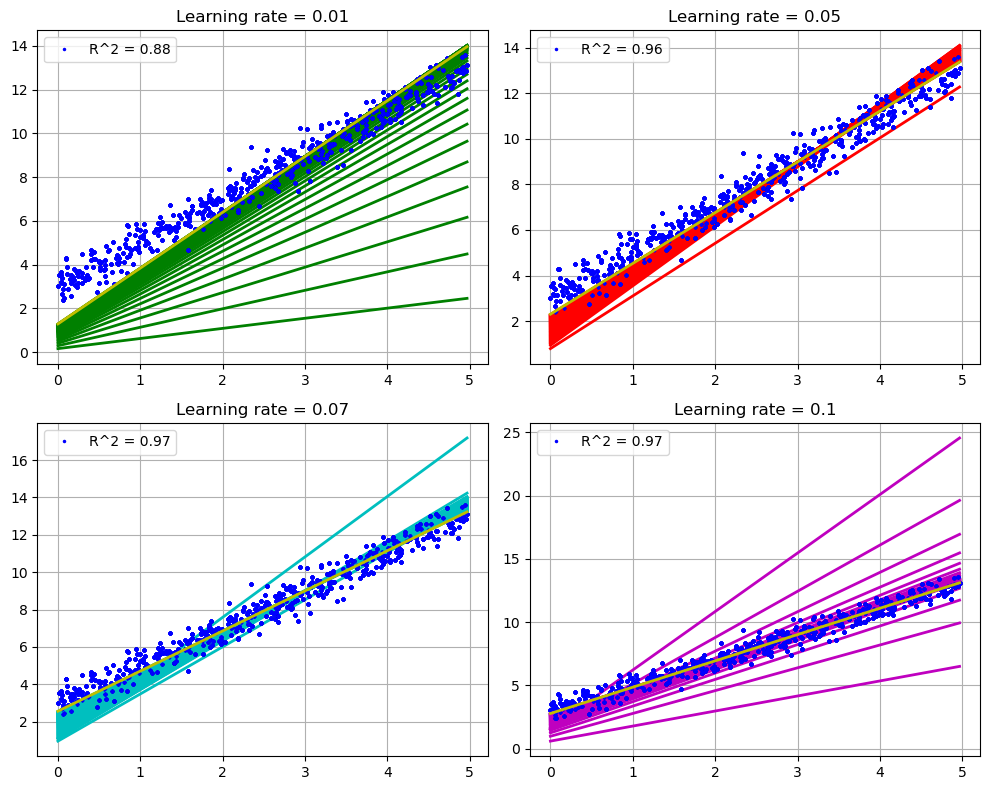

In [27]:
eta_values = [0.01, 0.05, 0.07, 0.1]
n_iter = 50

colors = ['g', 'r', 'c', 'm']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0s, beta1s, mse = gradient_descent(x=x, y=y, eta=eta, n_iter=n_iter, beta0=beta0, beta1=beta1)
    for i in range(n_iter):
        yhat = beta0s[i] + beta1s[i] * x
        axs[idx].plot(x, y, 'b.', markersize=3)
        if(i == n_iter - 1):
            axs[idx].plot(x, yhat, f'y-', linewidth=2)
        else:
            axs[idx].plot(x, yhat, f'{color}-', linewidth=2)
        axs[idx].set_title('Learning rate = ' + str(eta))
        axs[idx].grid('on')
    # Calculate the final R^2 value
    yhat = beta0s[-1] + beta1s[-1] * x
    ybar = np.mean(y)
    SS_tot = np.sum((y - ybar)**2)
    SS_res = np.sum((y - yhat)**2)
    R2 = 1 - SS_res / SS_tot
    # Add R2 as a legend to the plot
    axs[idx].legend([f'R^2 = {R2:.2f}'])

plt.tight_layout()
plt.show()

## (5) Implement the backtracking line search method (https://www.cs.cmu.edu/~ggordon/10725-F12/slides/05-gd-revisited.pdf) for using adapative learning rates at different steps, and redo parts (2)-(4). Does it seem to improve the speed of convergence over a constant learning rate?

In [28]:
def backtracking(x, y, eta, n_iter, t, beta0=0, beta1=0):

    mse = np.zeros(n_iter)
    beta0s = np.zeros(n_iter)
    beta1s = np.zeros(n_iter)

    beta0s[0] = beta0
    beta1s[0] = beta1
    mse[0] = np.mean((y - (beta0 + beta1 * x))**2)
    
    for i in range(n_iter):
        
        yhat = beta0 + beta1 * x
        
        grad_beta0 = -2 * np.mean(y - yhat)
        grad_beta1 = -2 * np.mean((y - yhat) * x)

        beta0 = beta0 - eta * grad_beta0
        beta1 = beta1 - eta * grad_beta1

        mse[i] = np.mean((y - yhat)**2)

        if  mse[i-1] - eta/2 * np.sqrt(grad_beta0**2 + grad_beta1**2) < mse[i]: # CHANGE: added this and t parameter :)
            eta = t*eta
        
        beta0s[i] = beta0
        beta1s[i] = beta1
    return beta0s, beta1s, mse

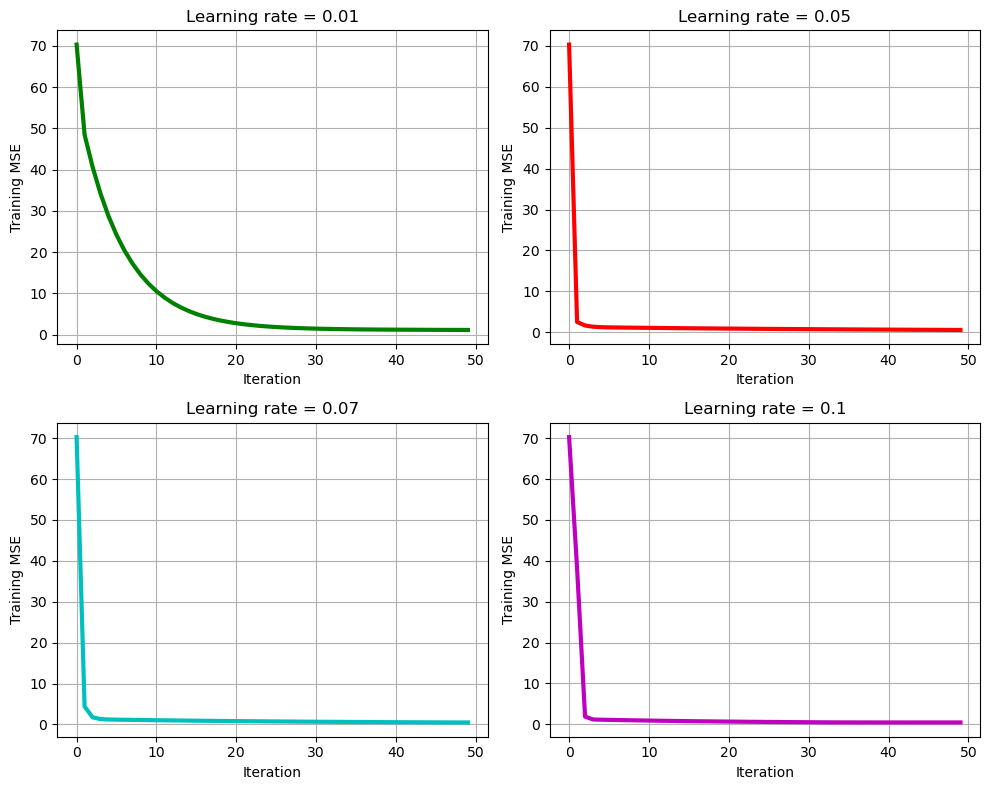

In [29]:
eta_values = [0.01, 0.05, 0.07, 0.1]
n_iter = 50

colors = ['g', 'r', 'c', 'm']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0, beta1, mse = backtracking(x=x, y=y, eta=eta, n_iter=n_iter, t = .5, beta0=beta0, beta1=beta1)
    axs[idx].plot(mse, f'{color}-', linewidth=3)
    axs[idx].set_xlabel('Iteration')
    axs[idx].set_ylabel('Training MSE')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].grid('on')

plt.tight_layout()
plt.show()

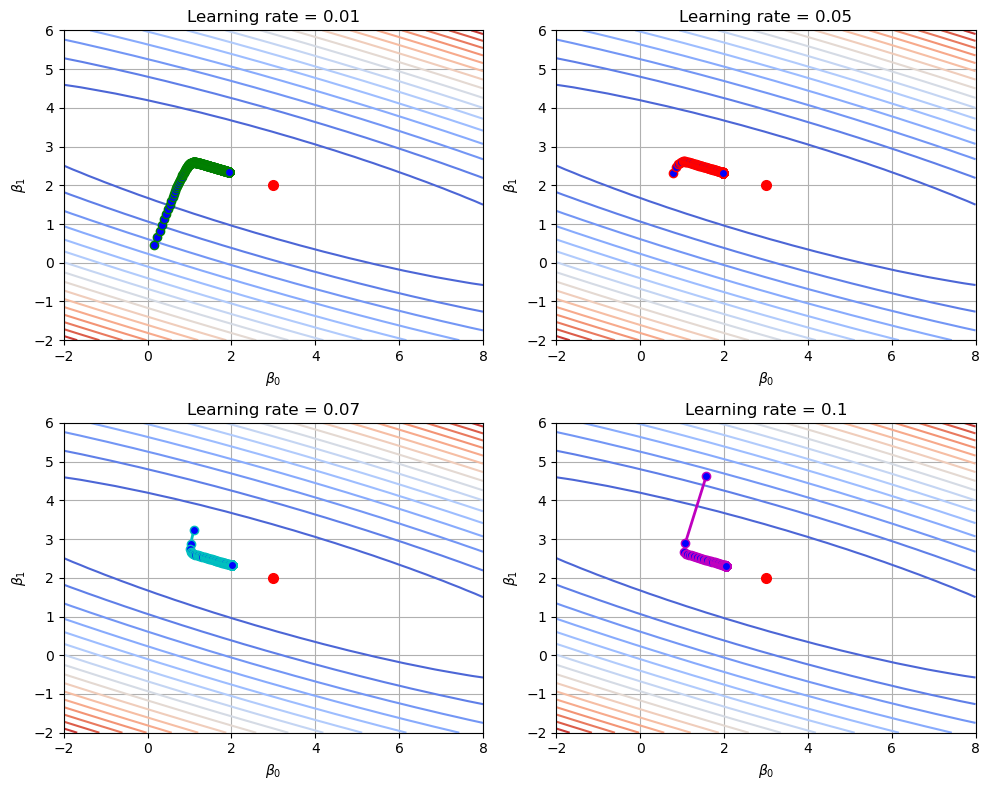

In [30]:
# Display the trajectory of gradient descent on top of level sets, for the different values of $\eta$

n = 50

beta0 = np.linspace(-2,8,n)
beta1 = np.linspace(-2,6,n)
B0, B1 = np.meshgrid(beta0, beta1)

MSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        yhat = B0[i,j] + B1[i,j] * x
        MSE[i,j] = np.mean((y - yhat)**2)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

eta_values = [0.01, 0.05, 0.07, 0.1]
colors = ['g', 'r', 'c', 'm']

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0s, beta1s, mse = backtracking(x=x, y=y, eta=eta, n_iter=500, t = 0.5, beta0=beta0, beta1=beta1) # CHANGE
    axs[idx].contour(B0, B1, MSE, 20, cmap=cm.coolwarm)
    axs[idx].plot(beta0s, beta1s, f'{color}-', linewidth=2, marker='o', markerfacecolor='b', markersize=6)
    axs[idx].set_xlabel(r'$\beta_0$')
    axs[idx].set_ylabel(r'$\beta_1$')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].plot(3,2,'ro', markersize=7)
    axs[idx].grid('on')

# plt.plot(xvals, yvals, color=colors[count], linestyle='dashed', linewidth=2,
                #  marker='o', markerfacecolor='blue', markersize=6)

plt.tight_layout()
plt.show()

## (6) Implement stochastic gradident descent (with a fixed learning rate) and make the same plots as in Parts (2)-(4).


In [33]:
def sgd(x, y, eta, T, mini_batches, beta0=0, beta1=0):
    mse_list = []
    beta0s = []
    beta1s = []

    beta0s.append(beta0)
    beta1s.append(beta1)

    n = len(y)
    batch_size = n // mini_batches

    for t in range(T):
        # Shuffle the data
        indices = np.random.permutation(n)
        x_shuffled = x[indices]
        y_shuffled = y[indices]

        for i in range(mini_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Compute predictions
            y_pred = beta0 + beta1 * x_batch

            # Compute gradients
            error = y_pred - y_batch
            gradient_beta0 = 2 * np.mean(error)
            gradient_beta1 = 2 * np.mean(error * x_batch)

            # Update parameters
            beta0 -= eta * gradient_beta0
            beta1 -= eta * gradient_beta1

        # Store parameters
        beta0s.append(beta0)
        beta1s.append(beta1)

        # Compute and store MSE
        y_pred_full = beta0 + beta1 * x
        mse = np.mean((y - y_pred_full) ** 2)
        mse_list.append(mse)

    return beta0s, beta1s, mse_list

In [15]:
def sgd(X, y, lr=0.01, epochs=1000, batch_size=32, tol=1e-3):
    n_samples, n_features = X.shape
    weights = np.random.randn(n_features)
    bias = np.random.randn()

    mse_list = []
    beta0s = []
    beta1s = []

    def predict(X):
        return np.dot(X, weights) + bias

    def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def gradient(X_batch, y_batch):
        y_pred = predict(X_batch)
        error = y_pred - y_batch
        gradient_weights = np.dot(X_batch.T, error) / X_batch.shape[0]
        gradient_bias = np.mean(error)
        return gradient_weights, gradient_bias

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            gradient_weights, gradient_bias = gradient(X_batch, y_batch)
            weights -= lr * gradient_weights
            bias -= lr * gradient_bias

        y_pred = predict(X)
        loss = mean_squared_error(y, y_pred)
        mse_list.append(loss)
        beta0s.append(bias)
        beta1s.append(weights[1])  # Assuming the second weight corresponds to beta1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss {loss}")

        if np.linalg.norm(gradient_weights) < tol:
            print("Convergence reached.")
            break

    return mse_list, beta0s, beta1s

In [46]:
def STGD (x, y, eta, n_iter, m, beta0=0, beta1=0):
    mse = np.zeros(n_iter)
    beta0s = np.zeros(n_iter)
    beta1s = np.zeros(n_iter)

    beta0s[0] = beta0
    beta1s[0] = beta1
    mse[0] = np.mean((y - (beta0 + beta1 * x))**2)
    for i in range(n_iter):
        for j in range(0, len(x), m):
            x_mini = x[j:j+m]
            y_mini = y[j:j+m]
            yhat = beta0 + beta1 * x_mini
            grad_beta0 = -2 * np.mean(y_mini - yhat)
            grad_beta1 = -2 * np.mean((y_mini - yhat) * x_mini)
            beta0 = beta0 - eta * grad_beta0
            beta1 = beta1 - eta * grad_beta1
        mse[i] = np.mean((y - (beta0 + beta1 * x))**2)
        beta0s[i] = beta0
        beta1s[i] = beta1
    return beta0s, beta1s, mse

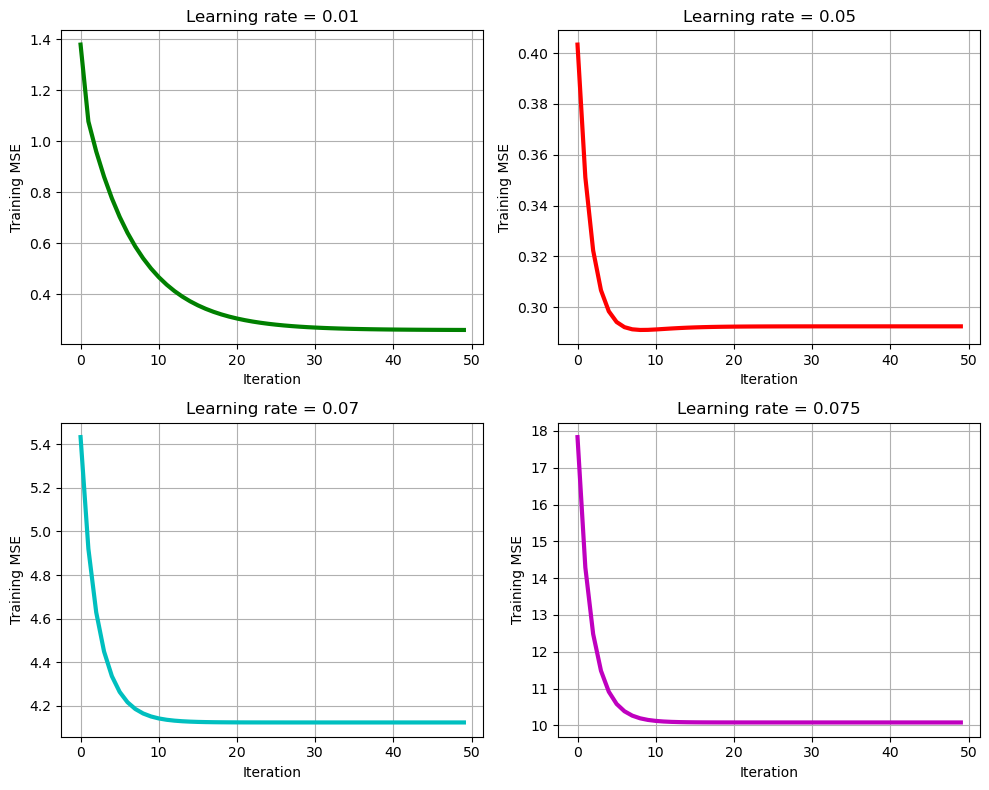

In [47]:
eta_values = [0.01, 0.05, 0.07, 0.075]
n_iter = 50

colors = ['g', 'r', 'c', 'm']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0, beta1, mse = STGD(x=x, y=y, eta=eta, n_iter=n_iter, m=30, beta0=beta0, beta1=beta1)
    axs[idx].plot(mse, f'{color}-', linewidth=3)
    axs[idx].set_xlabel('Iteration')
    axs[idx].set_ylabel('Training MSE')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].grid('on')

plt.tight_layout()
plt.show()

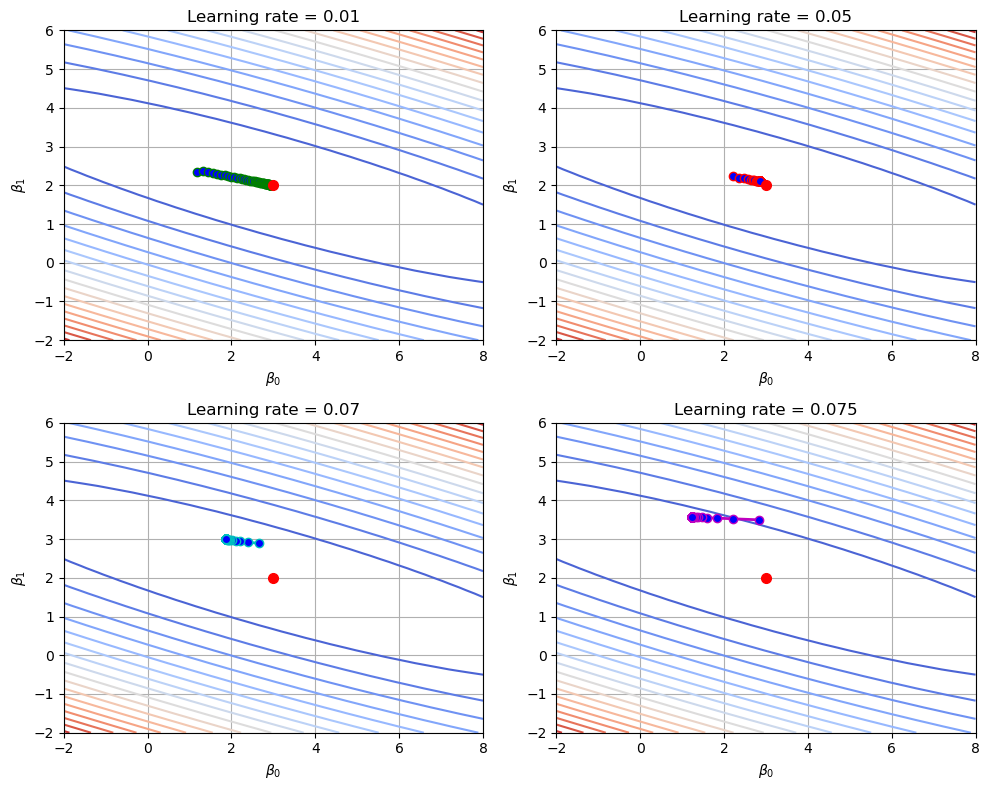

In [48]:
# Display the trajectory of gradient descent on top of level sets, for the different values of $\eta$

n = 50

beta0 = np.linspace(-2,8,n)
beta1 = np.linspace(-2,6,n)
B0, B1 = np.meshgrid(beta0, beta1)

MSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        yhat = B0[i,j] + B1[i,j] * x
        MSE[i,j] = np.mean((y - yhat)**2)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

eta_values = [0.01, 0.05, 0.07, 0.075]
colors = ['g', 'r', 'c', 'm']

for idx, (eta, color) in enumerate(zip(eta_values, colors)):
    beta0 = 0
    beta1 = 0
    beta0s, beta1s, mse = STGD(x=x, y=y, eta=eta, n_iter=500, m=30, beta0=beta0, beta1=beta1)
    axs[idx].contour(B0, B1, MSE, 20, cmap=cm.coolwarm)
    axs[idx].plot(beta0s, beta1s, f'{color}-', linewidth=2, marker='o', markerfacecolor='b', markersize=6)
    axs[idx].set_xlabel(r'$\beta_0$')
    axs[idx].set_ylabel(r'$\beta_1$')
    axs[idx].set_title('Learning rate = ' + str(eta))
    axs[idx].plot(3,2,'ro', markersize=7)
    axs[idx].grid('on')

# plt.plot(xvals, yvals, color=colors[count], linestyle='dashed', linewidth=2,
                #  marker='o', markerfacecolor='blue', markersize=6)

plt.tight_layout()
plt.show()